# Dowload environnement
#### Split in training / validation set

In [1]:
import os
import grid2op
from env_wrapper import Grid2opEnvWrapper
from grid2op.Reward import RedispReward, L2RPNReward, EpisodeDurationReward

### REWARD FUNCTION
reward_function=L2RPNReward

env_name = "l2rpn_case14_sandbox"
base_path = os.path.expanduser("/Users/mariannelado-roy/data_grid2op")
train_dir = os.path.join(base_path, f"{env_name}_train/")
val_dir = os.path.join(base_path, f"{env_name}_val/")
test_dir = os.path.join(base_path, f"{env_name}_test/")

def directories_exist(train_path, val_path, test_path):
    return os.path.exists(train_path) and os.path.exists(val_path) and os.path.exists(test_path)

# Make environment
env = grid2op.make(env_name, reward_class=reward_function)

if directories_exist(train_dir, val_dir, test_dir):
    print("Directories already exist. Skipping train-val-test split.")
else:
    print("Directories do not exist. Proceeding with train-val-test split.")
    # Perform the split
    try:
        nm_env_train, nm_env_val, nm_env_test = env.train_val_split_random(
            pct_val=10, # 10% validation
            pct_test=10, # 10% test
            add_for_train="train",
            add_for_val="val",
            add_for_test="test"
        )
        print(f"Training environment created: {nm_env_train}")
        print(f"Validation environment created: {nm_env_val}")
        print(f"Test environment created: {nm_env_test}")
    except OSError as e:
        print(f"An error occurred during splitting: {e}")


Directories already exist. Skipping train-val-test split.



# Create the environments


In [3]:
env_config = {
    # "backend_cls": ,
    # "backend_options": {},
    "env_name": "l2rpn_case14_sandbox", # "l2rpn_neurips_2020_track1_small"
    "env_is_test": False,
    # "obs_attr_to_keep": ["gen_p", "p_or" ,"load_p", "rho", "line_status"], # "gen_q", "gen_v",
    "act_type": "discrete", # "discrete" "box" "multi_discrete"
    # "act_attr_to_keep": ["change_line_status", "set_line_status_simple", "set_bus"], # set_line_status
    "reward_class": reward_function, # EpisodeDurationReward,
}

# Training environnement
train_env_config = env_config.copy()
train_env_config["data_set"] = "train"
train_env = Grid2opEnvWrapper(env_config)

# Validation environnement
val_env_config = env_config.copy()
val_env_config["data_set"] = "val"
val_env = Grid2opEnvWrapper(val_env_config)

# Training

In [ ]:
from stable_baselines3 import PPO, DQN, A2C
from sb3_contrib import ARS, QRDQN, TRPO, RecurrentPPO
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor


########## TRAINING PARAMETERS #################### 
N_TIMESTEP = 100000
N_EVAL_EPISODES=5
EVAL_FREQ = 100
################################################### 


monitor_env = Monitor(val_env, filename='./monitor_log', allow_early_resets=True)
log_dir = "./tensorboard_logs/"

# List of algorithms to train
# algorithms = [PPO, DQN, A2C, ARS, QRDQN, TRPO]
algorithms = [PPO]

# Loop over each algorithm
for algo in algorithms:
    # Define the model path and tensorboard log name dynamically
    model_name = algo.__name__
    tb_log_name = f"{model_name}_default_sandbox"
    model_path = f"./{model_name}_default_sandbox"

    # Create Call back:
    eval_callback = EvalCallback( 
        eval_env=monitor_env, 
        n_eval_episodes=N_EVAL_EPISODES,
        eval_freq=EVAL_FREQ, 
        log_path = model_path, 
        best_model_save_path=model_path,
        deterministic=True, 
        render=False,
        verbose=0 )


    # Initialize the algorithm with custom hyperparameters
    sb3_algo = algo(
        "MlpPolicy",
        # "LinearPolicy",
        # "MlpLstmPolicy",
        train_env,
        verbose=0,
        tensorboard_log=log_dir,
    )

    # Train the model
    sb3_algo.learn(
        total_timesteps=N_TIMESTEP, 
        tb_log_name=tb_log_name,
        callback=eval_callback
    )

    # Save the model
    sb3_algo.save(model_path+'/'+model_name)

    print(f"{model_name} model saved at {model_path}")


PPO model saved at ./PPO_default_sandbox


#### Look at evaluations

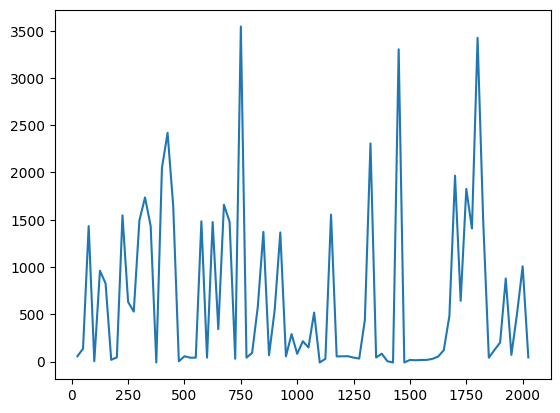

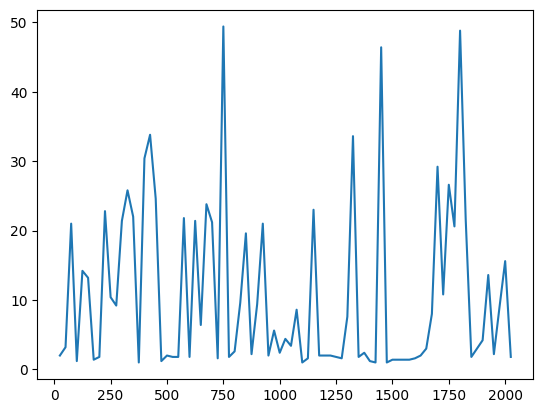

In [7]:
import numpy as np
import matplotlib.pyplot as plt
data = np.load(model_path+'/evaluations.npz')

results = np.mean(data['results'],axis=1)
ep_len = np.mean(data['ep_lengths'],axis=1)
t = data['timesteps']

plt.figure()
plt.plot(t,results)
plt.figure()
plt.plot(t,ep_len)

# Test set

### Compare to baseline agent

In [11]:
from grid2op.Runner import Runner
from grid2op.Agent import DoNothingAgent, TopologyGreedy, PowerLineSwitch, RandomAgent
from agent_wrapper import Grid2opAgentWrapper

# DEFINE TRAIN AGENT TO TEST HERE ##################
algo = PPO
####################################################

# Create test environnement
test_env_config = env_config.copy()
test_env_config["data_set"] = "test"
test_env = Grid2opEnvWrapper(test_env_config)

# Testing parameters
nb_episode_test = 10
seeds_test_env = tuple(range(nb_episode_test))  # Seeds for the environment
seeds_test_agent = tuple(range(nb_episode_test))  # Seeds for the agent

# Define the model path 
model_name = algo.__name__
model_path = f"./{model_name}_default_sandbox"

# Load the trained model
sb3_algo_to_test = algo.load(model_path+'/'+model_name, env=test_env)

# Convert to grid2op agent
my_agent = Grid2opAgentWrapper(test_env, sb3_algo_to_test)

runner = Runner(**test_env._g2op_env.get_params_for_runner(),
                agentClass=None,
                agentInstance=my_agent)

res = runner.run(nb_episode=nb_episode_test,
                env_seeds=seeds_test_env,
                agent_seeds=seeds_test_agent,
                # episode_id=ts_ep_test,
                add_detailed_output=True,
                path_save=model_path+"/test"
                )

# Baseline agents:
baseline_agents= [RandomAgent]
for baseline_agent in baseline_agents : 
    model_name = baseline_agent.__name__
    bmodel_path = f"./baseline/{model_name}"
    
    brunner = Runner(**test_env._g2op_env.get_params_for_runner(),
                agentClass=baseline_agent)

    bres = brunner.run(nb_episode=nb_episode_test,
                 env_seeds=seeds_test_env,
                 agent_seeds=seeds_test_agent,
                 # episode_id=ts_ep_test,
                 add_detailed_output=True,
                 path_save=bmodel_path
                 )

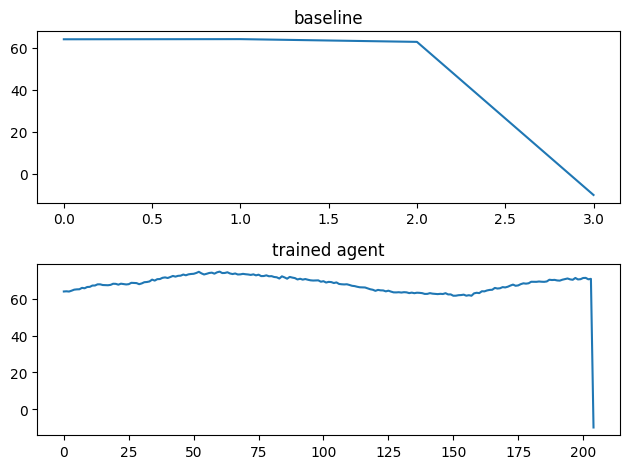

In [12]:
n='09'
baseline_agent = np.load( bmodel_path+'/00{}/rewards.npz'.format(n))['data'] #baseline
trained_agent = np.load( model_path+'/test/00{}/rewards.npz'.format(n))['data']
nsteps = np.arange(len(baseline_agent))

fig, ax = plt.subplots(2,1)
ax[0].set_title('baseline')
ax[0].plot(nsteps, baseline_agent, '-')
ax[1].set_title('trained agent')
ax[1].plot(nsteps,trained_agent, '-')
plt.tight_layout()
